# Privacy Audit - Four-Stage Privacy Risk Assessment

Compare privacy risks across four stages:
- **Stage0_Base**: Original pretrained model
- **Stage1_SFT**: Supervised fine-tuned model (canaries in training data)
- **Stage2a_DPO_NoCanary**: DPO trained without canary preference pairs
- **Stage2b_DPO_WithCanary**: DPO trained with canary preference pairs

**Audit Metrics:**
- MIA (Membership Inference Attack)
- Canary Extraction (LogProb + Rank)
- Internal Signals (Perplexity)

**Prerequisites:**
Upload the following to Colab:
- `data/canary_output.txt`
- `data/wiki_trimmed_with_canary.jsonl`
- `models/stage1_sft/` folder
- `models/stage2_dpo_no_canary/` folder
- `models/stage2_dpo_with_canary/` folder

## 1. Install Dependencies

In [ ]:
!pip install -q transformers peft accelerate pandas matplotlib seaborn

## 2. Configure Paths & Load Models

In [1]:
import torch
import json
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Detect device
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using device: {DEVICE}")

BASE_MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

# Local paths
LOCAL_PATHS = {
    "sft": "models/stage1_sft",
    "dpo_no_canary": "models/stage2_dpo_no_canary",
    "dpo_with_canary": "models/stage2_dpo_with_canary",
    "canary_file": "data/canary_output.txt",
    "wiki_file": "data/wiki_trimmed_with_canary.jsonl",
}

# Colab paths
COLAB_PATHS = {
    "sft": "./stage1_sft",
    "dpo_no_canary": "./stage2_dpo_no_canary",
    "dpo_with_canary": "./stage2_dpo_with_canary",
    "canary_file": "./data/canary_output.txt",
    "wiki_file": "./data/wiki_trimmed_with_canary.jsonl",
}

# Auto-select paths
if os.path.exists(LOCAL_PATHS["sft"]):
    PATHS = LOCAL_PATHS
else:
    PATHS = COLAB_PATHS

print(f"SFT model: {PATHS['sft']}")
print(f"DPO-no-canary model: {PATHS['dpo_no_canary']}")
print(f"DPO-with-canary model: {PATHS['dpo_with_canary']}")

Using device: cuda
SFT model: ./stage1_sft
DPO-no-canary model: ./stage2_dpo_no_canary
DPO-with-canary model: ./stage2_dpo_with_canary


In [2]:
# Four-stage model configuration
# (base_model_path, adapter_path_or_None)
STAGES = {
    "Stage0_Base": (BASE_MODEL_NAME, None),
    "Stage1_SFT": (BASE_MODEL_NAME, PATHS["sft"]),
    "Stage2a_DPO_NoCanary": (BASE_MODEL_NAME, PATHS["dpo_no_canary"]),
    "Stage2b_DPO_WithCanary": (BASE_MODEL_NAME, PATHS["dpo_with_canary"]),
}

In [3]:
def load_model_and_tokenizer(base_name, adapter_path=None):
    """Load a model with optional PEFT adapter."""
    tokenizer = AutoTokenizer.from_pretrained(
        adapter_path if adapter_path else base_name
    )
    model = AutoModelForCausalLM.from_pretrained(
        base_name,
        device_map="auto" if DEVICE == "cuda" else None,
        torch_dtype=torch.float16,
    )
    if adapter_path:
        model = PeftModel.from_pretrained(model, adapter_path)
    if DEVICE != "cuda":
        model = model.to(DEVICE)
    model.eval()
    return model, tokenizer

# Load all four stages
models = {}
for stage_name, (base, adapter) in STAGES.items():
    print(f"Loading {stage_name}...")
    models[stage_name] = load_model_and_tokenizer(base, adapter)
    print(f"  {stage_name} loaded!")

print(f"\nAll {len(models)} stages loaded.")

Loading Stage0_Base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage0_Base loaded!
Loading Stage1_SFT...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage1_SFT loaded!
Loading Stage2a_DPO_NoCanary...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage2a_DPO_NoCanary loaded!
Loading Stage2b_DPO_WithCanary...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage2b_DPO_WithCanary loaded!

All 4 stages loaded.


## 3. Load Data

In [4]:
# Load canaries
with open(PATHS["canary_file"]) as f:
    canaries = [l.strip() for l in f if l.strip()]
print(f"Loaded {len(canaries)} canaries")

# Load normal texts (non-canary)
with open(PATHS["wiki_file"]) as f:
    normal_texts = []
    for line in f:
        text = json.loads(line)["text"]
        if "CANARY" not in text and "RARE_" not in text and "STRUCT_ID" not in text:
            normal_texts.append(text)
        if len(normal_texts) >= len(canaries):
            break
print(f"Loaded {len(normal_texts)} normal texts")

Loaded 10 canaries
Loaded 10 normal texts


## 4. MIA Audit

In [5]:
@torch.no_grad()
def membership_signal(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs, labels=inputs["input_ids"])
    return -outputs.loss.item()

print("Running MIA audit...")
mia_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"  {stage_name}...")
    canary_signals = [membership_signal(model, tokenizer, c) for c in canaries]
    normal_signals = [membership_signal(model, tokenizer, n) for n in normal_texts]
    
    mia_results[stage_name] = {
        "canary_mean": sum(canary_signals) / len(canary_signals),
        "normal_mean": sum(normal_signals) / len(normal_signals),
        "gap": sum(canary_signals) / len(canary_signals) - sum(normal_signals) / len(normal_signals)
    }

print("\nMIA Results:")
for stage, result in mia_results.items():
    print(f"  {stage}: canary={result['canary_mean']:.4f}, normal={result['normal_mean']:.4f}, gap={result['gap']:.4f}")

Running MIA audit...
  Stage0_Base...
  Stage1_SFT...
  Stage2a_DPO_NoCanary...
  Stage2b_DPO_WithCanary...

MIA Results:
  Stage0_Base: canary=-6.5467, normal=-2.7577, gap=-3.7891
  Stage1_SFT: canary=-6.3471, normal=-2.4983, gap=-3.8488
  Stage2a_DPO_NoCanary: canary=-6.3471, normal=-2.4983, gap=-3.8488
  Stage2b_DPO_WithCanary: canary=-6.3471, normal=-2.4983, gap=-3.8488


## 5. Canary Extraction Audit

In [6]:
@torch.no_grad()
def logprob_of_sequence(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits[:, :-1, :]
    target_ids = inputs["input_ids"][:, 1:]
    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = log_probs.gather(2, target_ids.unsqueeze(-1)).squeeze(-1)
    return token_log_probs.mean().item()

@torch.no_grad()
def topk_rank(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    # Use logits[0, -2] to predict the last token (causal LM alignment)
    logits = outputs.logits[0, -2]
    sorted_ids = torch.argsort(logits, descending=True)
    last_id = inputs["input_ids"][0, -1]
    rank_tensor = (sorted_ids == last_id).nonzero(as_tuple=True)[0]
    return rank_tensor.item() if len(rank_tensor) > 0 else 1000

print("Running Extraction audit...")
extraction_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"  {stage_name}...")
    logprobs = [logprob_of_sequence(model, tokenizer, c) for c in canaries]
    ranks = [topk_rank(model, tokenizer, c) for c in canaries]
    
    extraction_results[stage_name] = {
        "avg_logprob": sum(logprobs) / len(logprobs),
        "avg_rank": sum(ranks) / len(ranks)
    }

print("\nExtraction Results:")
for stage, result in extraction_results.items():
    print(f"  {stage}: logprob={result['avg_logprob']:.4f}, rank={result['avg_rank']:.1f}")

Running Extraction audit...
  Stage0_Base...
  Stage1_SFT...
  Stage2a_DPO_NoCanary...
  Stage2b_DPO_WithCanary...

Extraction Results:
  Stage0_Base: logprob=-6.5473, rank=199.9
  Stage1_SFT: logprob=-6.3469, rank=176.8
  Stage2a_DPO_NoCanary: logprob=-6.3469, rank=176.8
  Stage2b_DPO_WithCanary: logprob=-6.3469, rank=176.8


## 6. Internal Signals Audit

In [7]:
import math

@torch.no_grad()
def compute_perplexity(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs, labels=inputs["input_ids"])
    return math.exp(outputs.loss.item())

print("Running Internal Signals audit...")
internal_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"  {stage_name}...")
    canary_ppl = [compute_perplexity(model, tokenizer, c) for c in canaries]
    normal_ppl = [compute_perplexity(model, tokenizer, n) for n in normal_texts]
    
    internal_results[stage_name] = {
        "canary_ppl": sum(canary_ppl) / len(canary_ppl),
        "normal_ppl": sum(normal_ppl) / len(normal_ppl),
        "ppl_ratio": (sum(canary_ppl) / len(canary_ppl)) / (sum(normal_ppl) / len(normal_ppl))
    }

print("\nInternal Signals Results:")
for stage, result in internal_results.items():
    print(f"  {stage}: canary_ppl={result['canary_ppl']:.2f}, normal_ppl={result['normal_ppl']:.2f}, ratio={result['ppl_ratio']:.4f}")

Running Internal Signals audit...
  Stage0_Base...
  Stage1_SFT...
  Stage2a_DPO_NoCanary...
  Stage2b_DPO_WithCanary...

Internal Signals Results:
  Stage0_Base: canary_ppl=857.94, normal_ppl=16.63, ratio=51.5963
  Stage1_SFT: canary_ppl=706.78, normal_ppl=12.70, ratio=55.6623
  Stage2a_DPO_NoCanary: canary_ppl=706.78, normal_ppl=12.70, ratio=55.6623
  Stage2b_DPO_WithCanary: canary_ppl=706.78, normal_ppl=12.70, ratio=55.6623


## 7. Summary Report

In [8]:
import pandas as pd

# Aggregate all results
summary = []
for stage in models.keys():
    summary.append({
        "Stage": stage,
        "MIA_Gap": mia_results[stage]["gap"],
        "Avg_LogProb": extraction_results[stage]["avg_logprob"],
        "Avg_Rank": extraction_results[stage]["avg_rank"],
        "Canary_PPL": internal_results[stage]["canary_ppl"],
        "PPL_Ratio": internal_results[stage]["ppl_ratio"]
    })

df = pd.DataFrame(summary)
print("=" * 80)
print("Privacy Audit Summary (4 Stages)")
print("=" * 80)
print(df.to_string(index=False))

# Save results
os.makedirs("reports", exist_ok=True)
df.to_csv("reports/privacy_audit_summary.csv", index=False)
print("\nResults saved to reports/privacy_audit_summary.csv")

Privacy Audit Summary (4 Stages)
                 Stage   MIA_Gap  Avg_LogProb  Avg_Rank  Canary_PPL  PPL_Ratio
           Stage0_Base -3.789050    -6.547266     199.9  857.944628  51.596331
            Stage1_SFT -3.848833    -6.346875     176.8  706.776982  55.662265
  Stage2a_DPO_NoCanary -3.848833    -6.346875     176.8  706.776982  55.662265
Stage2b_DPO_WithCanary -3.848833    -6.346875     176.8  706.776982  55.662265

Results saved to reports/privacy_audit_summary.csv


## 8. Visualization

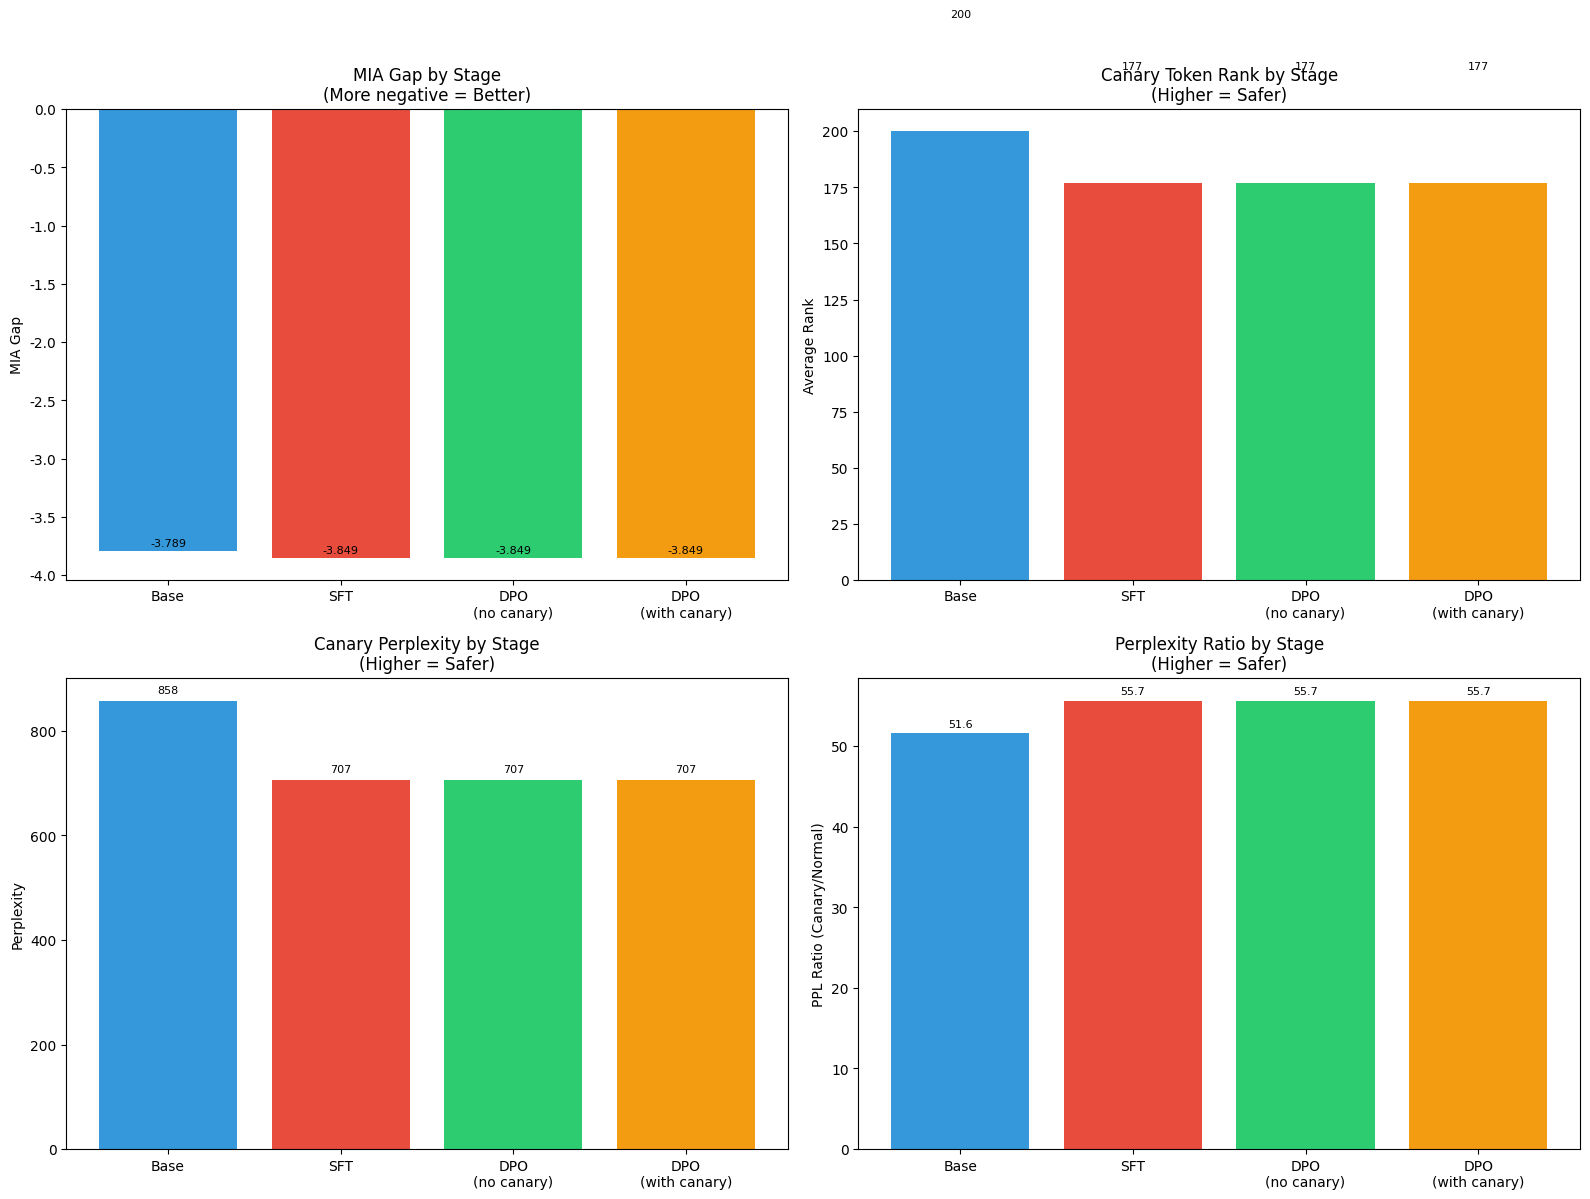

Chart saved to reports/privacy_audit_4stage.png


In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

stages = df["Stage"].tolist()
x = np.arange(len(stages))
labels = ["Base", "SFT", "DPO\n(no canary)", "DPO\n(with canary)"]
colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12"]

# 1. MIA Gap
ax1 = axes[0, 0]
bars1 = ax1.bar(x, df["MIA_Gap"], color=colors)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylabel("MIA Gap")
ax1.set_title("MIA Gap by Stage\n(More negative = Better)")
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars1, df["MIA_Gap"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Average Rank
ax2 = axes[0, 1]
bars2 = ax2.bar(x, df["Avg_Rank"], color=colors)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylabel("Average Rank")
ax2.set_title("Canary Token Rank by Stage\n(Higher = Safer)")
for bar, val in zip(bars2, df["Avg_Rank"]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8)

# 3. Canary Perplexity
ax3 = axes[1, 0]
bars3 = ax3.bar(x, df["Canary_PPL"], color=colors)
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.set_ylabel("Perplexity")
ax3.set_title("Canary Perplexity by Stage\n(Higher = Safer)")
for bar, val in zip(bars3, df["Canary_PPL"]):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8)

# 4. PPL Ratio
ax4 = axes[1, 1]
bars4 = ax4.bar(x, df["PPL_Ratio"], color=colors)
ax4.set_xticks(x)
ax4.set_xticklabels(labels)
ax4.set_ylabel("PPL Ratio (Canary/Normal)")
ax4.set_title("Perplexity Ratio by Stage\n(Higher = Safer)")
for bar, val in zip(bars4, df["PPL_Ratio"]):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("reports/privacy_audit_4stage.png", dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved to reports/privacy_audit_4stage.png")

## 9. DPO Variant Comparison

Side-by-side comparison of DPO-no-canary vs DPO-with-canary.

In [10]:
# DPO variant comparison table
dpo_nc = df[df["Stage"] == "Stage2a_DPO_NoCanary"].iloc[0]
dpo_wc = df[df["Stage"] == "Stage2b_DPO_WithCanary"].iloc[0]

metrics = ["MIA_Gap", "Avg_LogProb", "Avg_Rank", "Canary_PPL", "PPL_Ratio"]
comparison = []
for m in metrics:
    comparison.append({
        "Metric": m,
        "DPO_NoCanary": dpo_nc[m],
        "DPO_WithCanary": dpo_wc[m],
        "Delta": dpo_wc[m] - dpo_nc[m],
    })

comp_df = pd.DataFrame(comparison)
print("DPO Variant Comparison:")
print(comp_df.to_string(index=False))

DPO Variant Comparison:
     Metric  DPO_NoCanary  DPO_WithCanary  Delta
    MIA_Gap     -3.848833       -3.848833    0.0
Avg_LogProb     -6.346875       -6.346875    0.0
   Avg_Rank    176.800000      176.800000    0.0
 Canary_PPL    706.776982      706.776982    0.0
  PPL_Ratio     55.662265       55.662265    0.0


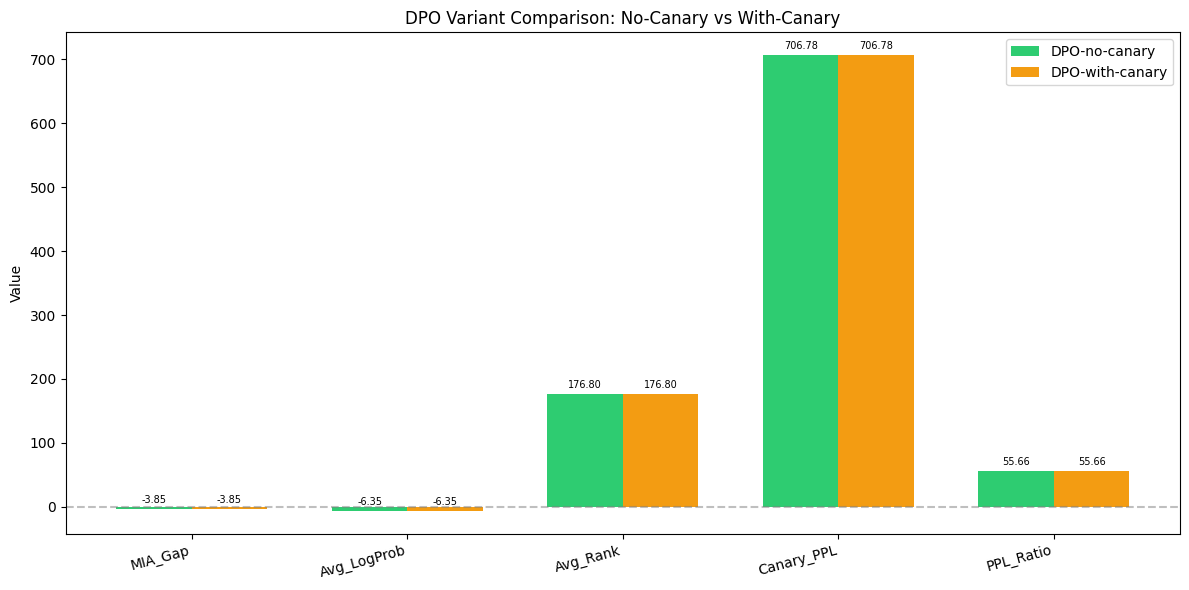

Chart saved to reports/dpo_variant_comparison.png


In [11]:
# DPO variant side-by-side bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

bars_nc = ax.bar(x - width/2, [dpo_nc[m] for m in metrics], width,
                 label='DPO-no-canary', color='#2ecc71')
bars_wc = ax.bar(x + width/2, [dpo_wc[m] for m in metrics], width,
                 label='DPO-with-canary', color='#f39c12')

ax.set_ylabel('Value')
ax.set_title('DPO Variant Comparison: No-Canary vs With-Canary')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15, ha='right')
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

for bar in list(bars_nc) + list(bars_wc):
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig("reports/dpo_variant_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved to reports/dpo_variant_comparison.png")

In [12]:
print("Privacy audit complete!")
print(f"  Stages audited: {len(models)}")
print(f"  Results: reports/privacy_audit_summary.csv")
print(f"  Charts: reports/privacy_audit_4stage.png, reports/dpo_variant_comparison.png")

Privacy audit complete!
  Stages audited: 4
  Results: reports/privacy_audit_summary.csv
  Charts: reports/privacy_audit_4stage.png, reports/dpo_variant_comparison.png
